Name : Abhishek Vishal Phaltankar,
College : Pune Institue Of Computer Technology,
Email Id : avp1510@gmail.com,
Contact Number : 9881501510,
Project Name : Amazon Reccomendatio system.

# Importing Libraries

In [129]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
%matplotlib inline
from surprise import Reader,Dataset,SVD
from surprise.model_selection import cross_validate
import pickle

# Loading Dataset

In [78]:
df=pd.read_csv("amazon_reviews.csv",names=['user_id','product_id','rating','timestamp'])
df.head()

,user_id,product_id,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


# Analysis


In [79]:
df.shape

(7824482, 4)

In [80]:
df = df.iloc[:8000,0:]

In [81]:
print("Number Of Reviews : ",df.shape[0])
print("Number Of Columns : ",df.shape[1])

Number Of Reviews :  8000
Number Of Columns :  4


In [82]:
print("Number of Users : ",df['user_id'].nunique())
print("Number of Products : ",df['product_id'].nunique())
print("All Possible number of Ratings : ",df['rating'].nunique())

Number of Users :  7892
Number of Products :  1220
All Possible number of Ratings :  5


In [83]:
print("Unique rating values : ",df.rating.unique())# so rating is out of 5
print("Max Rating : ",df.rating.max())
print("Min Rating : ",df.rating.min())

Unique rating values :  [5. 1. 3. 2. 4.]
Max Rating :  5.0
Min Rating :  1.0


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_id     8000 non-null   object 
 1   product_id  8000 non-null   object 
 2   rating      8000 non-null   float64
 3   timestamp   8000 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 250.1+ KB


In [85]:
df.isnull().sum()# so null values

user_id       0
product_id    0
rating        0
timestamp     0
dtype: int64

In [86]:
df.duplicated().sum()# so no duplicate entries as well

0

In [87]:
df.rating.describe()

count    8000.000000
mean        3.936250
std         1.467551
min         1.000000
25%         3.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

# Visualization

In [88]:
#creating dataframe for visualisation
rating=pd.DataFrame(df.groupby("product_id")['rating'].mean())
rating['rate_count']=pd.DataFrame(df.groupby("product_id")['rating'].count())
rating.head(15)

,rating,rate_count
product_id,,
0132793040,5.000000,1
0321732944,5.000000,1
0439886341,1.666667,3
0511189877,4.500000,6
0528881469,2.851852,27
0558835155,3.000000,1
059400232X,5.000000,3
0594012015,2.000000,8
0594017343,1.000000,1


(array([147.,   6.,  64.,  17.,   8., 116.,  60., 168.,  82., 552.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

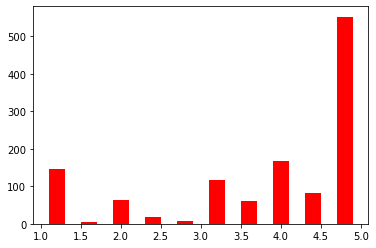

In [89]:
plt.hist(rating.rating,color='red',rwidth=0.5)

Text(0, 0.5, 'Count_Of_Rating')

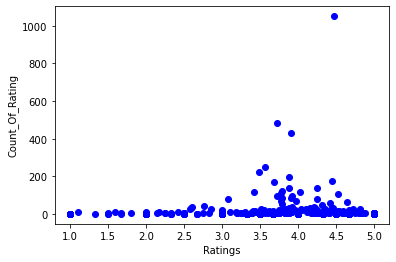

In [90]:
plt.scatter(rating.rating,rating.rate_count,color='blue')
plt.xlabel("Ratings")
plt.ylabel("Count_Of_Rating")

<AxesSubplot:xlabel='product_id'>

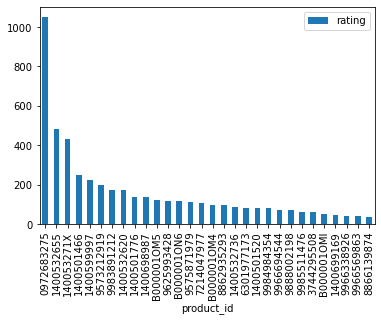

In [91]:
#most rated products
most_rated=pd.DataFrame(df.groupby('product_id')['rating'].count())
popular=most_rated.sort_values('rating',ascending=False)
popular.head(30).plot(kind='bar')

In [92]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1220 entries, 0132793040 to B000001ON6
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rating      1220 non-null   float64
 1   rate_count  1220 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 60.9+ KB


In [93]:
vote_count=rating.rate_count
vote_avg=rating.rating
vote_count.mean()
c=vote_avg.mean()

In [94]:
m=vote_count.quantile(0.95)#so to be in the top 95 percent min votes should be 55

In [95]:
top_rated=rating[(rating.rate_count>=55)&(rating.rate_count.notnull())&(rating.rating.notnull())]
top_rated.head()

,rating,rate_count
product_id,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


In [96]:
top_rated=top_rated.sort_values(by="rate_count",ascending=False)
top_rated.shape

(25, 2)

In [97]:
top_rated.head(15)

,rating,rate_count
product_id,,
0972683275,4.470980,1051
1400532655,3.727273,484
140053271X,3.900232,431
1400501466,3.560000,250
1400599997,3.490991,222
9573212919,3.879397,199
9983891212,4.442529,174
1400532620,3.684211,171
1400501776,3.884892,139


In [98]:
def get_top_weighted(x):
    R=x.rating
    v=x.rate_count
    return (v/(v+m)*R)+(m/(m+v)*c)

In [99]:
top_rated['wr']=top_rated.apply(get_top_weighted,axis=1)

In [100]:
top_rated=top_rated.sort_values(by='wr',ascending=False)
top_rated=top_rated.head(10)
top_rated

,rating,rate_count,wr
product_id,,,
9985511476,4.645161,62,4.467207
0972683275,4.470980,1051,4.460596
7214047977,4.523364,107,4.427013
9983891212,4.442529,174,4.387378
3744295508,4.416667,60,4.286879
1400698987,4.246377,138,4.201132
1400501520,4.243902,82,4.173766
B000001ON6,4.025424,118,4.002769
9888002198,3.971429,70,3.947461


Text(0.5, 1.0, 'rating count')

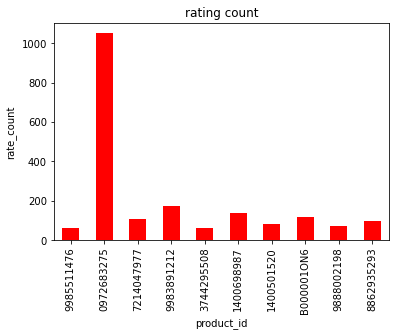

In [101]:
count_plot=top_rated['rate_count'].plot.bar(color='r')
count_plot.set_ylabel("rate_count")
count_plot.set_title("rating count")

Text(0.5, 1.0, 'average rating')

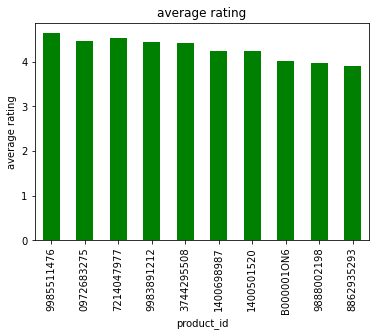

In [102]:
rateavg_plot=top_rated['rating'].plot.bar(color='g')
rateavg_plot.set_ylabel("average rating")
rateavg_plot.set_title("average rating")

Text(0.5, 1.0, 'weighted rating')

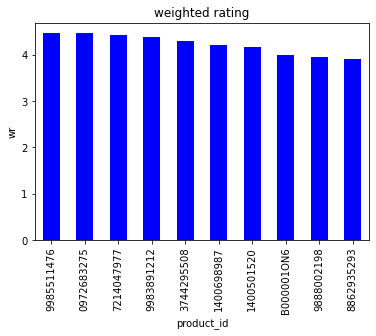

In [103]:
wr_plot=top_rated['wr'].plot.bar(color='b')
wr_plot.set_ylabel("wr")
wr_plot.set_title("weighted rating")

# Collaborative Filtering 

In [104]:

df['user_id'].nunique()

7892

In [105]:
df.head()

,user_id,product_id,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [106]:
#Matrix to create row per user_id and column per product_id
pivot_df=pd.pivot_table(df,index=['user_id'],columns='product_id',values='rating')
pivot_df.fillna(0,inplace=True)
pivot_df.head()

product_id,0132793040,0321732944,0439886341,0511189877,0528881469,0558835155,059400232X,0594012015,0594017343,0594017580,...,B000001OMR,B000001OMS,B000001OMT,B000001OMV,B000001OMW,B000001OMZ,B000001ON0,B000001ON2,B000001ON5,B000001ON6
user_id,,,,,,,,,,,,,,,,,,,,,
A00766851QZZUBOVF4JFT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01255851ZO1U93P8RKGE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0293130VTX2ZXA70JQS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A030530627MK66BD8V4LN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0402564TCEO67AUZFJO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
pivot_df.shape[0]

7892

In [108]:
#now to create a column for giving users quantitative names
pivot_df['user_index']=np.arange(0,pivot_df.shape[0],1)
pivot_df.head()

product_id,0132793040,0321732944,0439886341,0511189877,0528881469,0558835155,059400232X,0594012015,0594017343,0594017580,...,B000001OMS,B000001OMT,B000001OMV,B000001OMW,B000001OMZ,B000001ON0,B000001ON2,B000001ON5,B000001ON6,user_index
user_id,,,,,,,,,,,,,,,,,,,,,
A00766851QZZUBOVF4JFT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A01255851ZO1U93P8RKGE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A0293130VTX2ZXA70JQS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A030530627MK66BD8V4LN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A0402564TCEO67AUZFJO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [109]:
pivot_df.set_index(['user_index'],inplace=True)

In [126]:
pivot_df

product_id,0132793040,0321732944,0439886341,0511189877,0528881469,0558835155,059400232X,0594012015,0594017343,0594017580,...,B000001OMR,B000001OMS,B000001OMT,B000001OMV,B000001OMW,B000001OMZ,B000001ON0,B000001ON2,B000001ON5,B000001ON6
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7888,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
U,sigma,Vt=svds(pivot_df,k=50)#k is number of singular vallues and vectors to compute
#for decomposition of matrices

In [112]:
sigma

array([ 19.87460691,  19.90500413,  20.02498439,  20.15231168,
        20.71231518,  20.96147281,  21.11871208,  21.47091055,
        21.77154106,  22.11334439,  22.62275695,  22.7815715 ,
        23.08679276,  23.70472306,  24.51530134,  24.74017542,
        24.84156802,  25.17235822,  25.19920634,  25.53429067,
        25.63201124,  27.27636339,  27.56641876,  29.20046508,
        30.5608581 ,  32.08378551,  34.43835072,  35.24202037,
        35.56683849,  37.04051835,  37.33260323,  38.55138271,
        39.68626967,  39.82828562,  40.18805037,  41.44246581,
        43.01158571,  45.05292445,  46.3651227 ,  47.58150901,
        48.49336907,  52.04159867,  52.55205732,  57.61817057,
        58.41232747,  60.57355839,  61.8046387 ,  86.43198881,
        88.47247237, 148.10509864])

In [113]:
sigma=np.diag(sigma)

In [114]:
sigma#diagonal array for SVD


array([[ 19.87460691,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,  19.90500413,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,  20.02498439, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,  86.43198881,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
         88.47247237,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 148.10509864]])

In [115]:
user_predicted_ratings=np.dot(np.dot(U,sigma),Vt)

In [116]:
preds_df=pd.DataFrame(user_predicted_ratings,columns=pivot_df.columns)
preds_df.head()

product_id,0132793040,0321732944,0439886341,0511189877,0528881469,0558835155,059400232X,0594012015,0594017343,0594017580,...,B000001OMR,B000001OMS,B000001OMT,B000001OMV,B000001OMW,B000001OMZ,B000001ON0,B000001ON2,B000001ON5,B000001ON6
0,-1.446216e-32,-3.872476e-33,2.700682e-33,-2.904099e-32,1.051604e-30,-3.103886e-33,3.910033e-32,2.220578e-33,5.867972e-21,2.894460e-18,...,1.321393e-32,2.236219e-17,2.940587e-16,4.277447e-17,-4.194433e-32,-1.507173e-15,-1.711628e-31,-2.753421e-33,-1.188844e-32,2.174895e-16
1,-5.837842e-33,-1.794551e-33,7.484878e-33,-1.813222e-33,-9.236886e-33,-5.900362e-35,1.685190e-32,-1.527085e-33,3.734859e-21,1.803589e-18,...,2.483602e-32,5.361130e-19,-1.085490e-16,-8.380696e-18,-6.871743e-33,-6.122393e-17,1.513970e-32,-2.966036e-33,1.264046e-33,-1.129303e-17
2,-1.501133e-17,-4.835412e-18,5.118237e-18,-4.443061e-18,1.670958e-16,-1.763084e-18,-1.446006e-17,-7.958309e-19,5.219178e-09,-3.172160e-09,...,1.509634e-17,3.343403e-18,4.217275e-16,4.116821e-17,-9.362866e-18,1.913644e-16,-4.547476e-18,-1.144680e-17,1.881233e-18,-6.443640e-10
3,-1.200906e-17,-3.868329e-18,4.094589e-18,-3.554449e-18,1.336766e-16,-1.410468e-18,-1.156804e-17,-6.366647e-19,4.175342e-09,-2.537728e-09,...,1.207707e-17,2.674722e-18,3.373820e-16,3.293456e-17,-7.490293e-18,1.530915e-16,-3.637980e-18,-9.157440e-18,1.504987e-18,-5.154912e-10
4,1.137493e-34,3.693286e-35,-1.867939e-34,6.510203e-35,1.079275e-33,2.300335e-36,-3.506863e-34,4.135026e-35,-9.280502e-23,-4.596929e-20,...,-5.982207e-34,-2.493500e-20,1.643282e-18,1.934361e-19,1.904060e-34,8.248819e-19,-4.931485e-34,6.461332e-35,-3.175399e-35,1.794595e-19


In [128]:
#recommend item with highest predicted ratings
def recommend_product(userid,pivot_df,preds_df,num_recom):
    
    user_idx=userid-1#index starts with 0
    #conting user rating in ascending order
    sorted_usr_rating=pivot_df.iloc[user_idx].sort_values(ascending=False)
    #contains sorted user predictions
    sorted_usr_predictions=preds_df.iloc[user_idx].sort_values(ascending=False)
    
    temp=pd.concat([sorted_usr_rating,sorted_usr_predictions],axis=1)
    temp.index.name='Recommended Items'
    temp.columns=['user_ratings','user_predictions']
    
    temp=temp.loc[temp.user_ratings==0]
    temp=temp.sort_values('user_predictions',ascending=False)
    print('\nBelow are recommendations for user(',userid,')\n')
    
    print(temp.head(num_recom))
    

# Here we can get the recommndations

In [127]:
userid=121

num_recom=20
recommend_product(userid,pivot_df,preds_df,num_recom)


Below are recommendations for user( 121 )

                   user_ratings  user_predictions
Recommended Items                                
9984988074                  0.0      2.704136e-03
0594296420                  0.0      1.191704e-06
0594033926                  0.0      1.387655e-07
1616813873                  0.0      1.585318e-08
1400599997                  0.0      1.152203e-08
1400501784                  0.0      2.021541e-09
1400501474                  0.0      4.602043e-10
1400501741                  0.0      1.153061e-10
1400532736                  0.0      5.683433e-11
1615527613                  0.0      5.170965e-11
1400698987                  0.0      1.399736e-11
140053271X                  0.0      7.112990e-12
B000001OMI                  0.0      3.525266e-12
998498480X                  0.0      1.313598e-12
0972683275                  0.0      6.652509e-13
9985511476                  0.0      5.883404e-16
7214047977                  0.0      5.797801e-16
957321

In [130]:
pickle.dump(pivot_df,open('pivot_df.pkl','wb'))
pickle.dump(preds_df,open('preds_df.pkl','wb'))
pickle.dump(recommend_product,open('recommend.pkl','wb'))